# Various random walks
As stated in the previous notebook, there are many different possible "terrains" on which to conduct a random walk, consisting of different nodes and patterns of nodes and their connections.  In this notebook, we will re-visit the 1D and 2D grid random walks, and look into patterns of two, three, and four nodes.

In [3]:
from qiskit import *
from qiskit.visualization import *

backend = Aer.get_backend('qasm_simulator')

## 1D Random walk
Recall that the random walk in a single dimension produced a binomial distribution with parameters n=number of steps and p=0.5, separated, and staggered, resulting in n+1 columns with values in the range [-n,n] in steps of two.  Equivalently, there were $n + 1$ possible positions after a random walk of $n$ steps, and the kth position - the lowest being zero - would occur with a probability $\binom{n}{k}(\frac{1}{2})^n$.  It should be apparent enough that the height of the kth column in the resulting histogram is the probability of a random walk ending in the kth position, multiplied by the number of times the experiment is run - as such, when the number of shots is $2^n$, the heights of the columns are, approximately, the binomial coefficients, the values in the nth row of Pascal's Triangle.<sup><a name="myfootnote1">1</a></sup>

The code segment below allows us to make the results of our 1-D and 2-D random walks look "prettier" by converting states to numeral values.

<sup>[1](#myfootnote1)Pascal's triangle is also known as Yang Hui's triangle, Khayyam's triangle, and Tartaglia's triangle.</sup>

In [11]:
import matplotlib.pyplot as plt
import numpy as np
import math

REGISTER_LENGTH = 5
STEPS = 10
SHOTS = 2 ** STEPS

# This code was copied from the previous notebook
# Python's built-in binary to integer conversion doesn't account for signed values - do so with these:
CORRECTION_SLIDE = (2 ** REGISTER_LENGTH)
MAX = CORRECTION_SLIDE / 2 - 1

def dec(s_bin):
    xi = int(s_bin, 2)
    if (xi > MAX):
        return xi - CORRECTION_SLIDE
    return xi

def arrange_1d_data(counts):
    x = []
    val = []
    for each in counts:
        x.append(dec(each))
        val.append(counts[each])
    return x, val 

# The below method takes the results of a bi-axial walk and makes a more appealing visual
def arrange_2d_data(counts):
    x = []
    y = []
    val = []
    for each in counts:
        xb, yb = each.split(' ') # Retrieve binary coordinates
        xi, yi = dec(xb), dec(yb)
        x.append(xi) # Add to lists of coordinates
        y.append(yi)
        val.append(counts[each])
    return x, y, val

### Faster implementation
Remember in the previous implementation, how we implement a separate incrementer and decrementer, consisting of many controlled gates, at least half of which are not powered at any given time?  This is, of course, inefficient - so what is efficient?

If each bit's behavior in each step of a random walk could be converted to a unitary gate, these unitary gates could be made into chains - and compressed via matrix multiplication - instead of implemented so many times.  This is the simplest exponential speed-up case; however, it does not occur here.  The best we can do is to consider the behavior of each bit in each step as separately as possible, and implement that.  In this case, we will still consider positions on the graph to be encoded as unsigned/two's complement integers with overflow (producing what is technically a circle or a $2^n$-gon of nodes), though it would be possible to use Gray codes<sup><a name="myfootnote2">2</a></sup> or something like 1 <=> ...001, 2 <=> ...010, 3 <=> ...100, or 1 <=> ...001, 2 <=> ...011, 3 <=> ...111.  It is expected that the use of fewer bits will result in the need for fewer gates and thus produce a more efficient circuit.

In this case, begin with the least significant bit.  In every step on this graph, the least significant bit toggles.  This happens regardless of its value, those of the other bits, which node it steps to, or even the presence of other bits, and can be implemented conveniently with an x gate.  A register of one bit, or a random walk with on an axis of length 2, would have no choice anyhow, but to flip between 0 and 1 each step.
Next, consider the second-least significant bit, and a graph with nodes 00, 01, 10, and 11, connected in *that* order (we will consider other possibilities later).  Each step, that bit has half a chance of changing - it might, it might not.  For any one initial state of the register, this bit's changing or not changing indicates the choice of the next node between the two possible ones, even if neither changing nor not changing consistently corresponds to "incrementation" or "decrementation".  This can be implemented using a cx gate with a Hadamard coin as the control bit and the second-least significant bit as the target.
Next, consider the third-least significant bit, and the nodes connected in a cycle 000, 001, 010, 011, 100, 101, 110, and 111.  Thanks to the typical integer scheme, the two less significant bits will continue to traverse their porition of this state machine; we need only know when and how to change the third-least significant bit.  It changes in four cases: 000->111, 111->000, 011->100, and 100->011.  In general, it only changes, and always changes when *all* the bits less significant than it change - and when this happens, those bits all have the same value, and are thus all one either before or after their change.  This is the basis of the pattern used in the "crement" function below, which keeps an ancillary register with two fewer bits than the state register, which is repeatedly set to indicate whether the last so many digits are all one via a chain of Toffoli gates.

<sup>[2](#myfootnote2)Gray codes are an alternative scheme for corresponding numbers 0 to $2^n-1$ to the states of n bits, in which two adjacent numbers differ by only one bit.  Owing to the need for only one change in each step of a random walk, I suspect this may be implementable with very few gates.</sup>

In [12]:
def flip(circuit, coin): # Hadamard coins must be initialized for each flip
    circuit.initialize('0',coin)
    circuit.h(coin)

def crement(circuit, state, anc, coin):

    # Find initial ancillary states - how far do we have ones all the way back?
    circuit.initialize('0'*len(anc), anc)
    circuit.toffoli(state[0], state[1], anc[0])
    for s in range(1, len(anc)):
        circuit.toffoli(anc[s-1], state[s+1], anc[s])

    # Change the last two bits
    circuit.x(state[0])
    circuit.cx(coin, state[1])
 
    # Change for the ...111 -> ...000 case
    for s in range(2, len(state)):
       circuit.toffoli(coin, anc[s-2], state[s])
    
    # Re-calculate ancillary to check for ...000 -> ...111 case
    circuit.initialize('0'*len(anc), anc)
    circuit.toffoli(state[0], state[1], anc[0])
    circuit.toffoli(coin, anc[0], state[2])
    for s in range(1, len(anc)):
        circuit.toffoli(anc[s-1], state[s+1], anc[s]) # And change for that case as we go
        circuit.toffoli(coin, anc[s], state[s+2])    

Text(0.5, 1.0, 'Random walk on single axis')

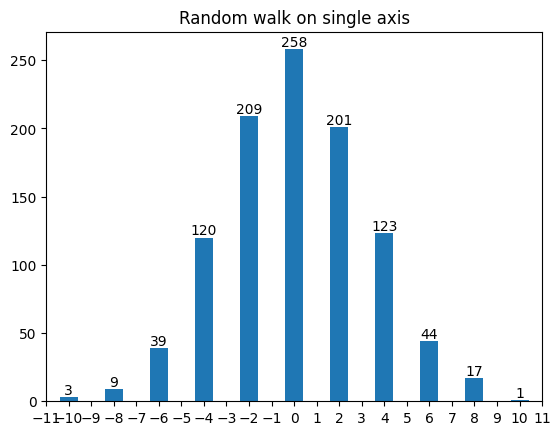

In [13]:
q_pos = QuantumRegister(REGISTER_LENGTH)
anc = QuantumRegister(REGISTER_LENGTH - 2)
c_pos = ClassicalRegister(REGISTER_LENGTH)
coin = QuantumRegister(1)
qc = QuantumCircuit(q_pos, anc, c_pos, coin)

for i in range(STEPS):
    flip(qc, coin)
    crement(qc, q_pos, anc, coin)

qc.measure(q_pos, c_pos)

job = execute(qc, backend, shots=SHOTS)
result = job.result()
counts = result.get_counts()

x, val = arrange_1d_data(counts)
fig, ax = plt.subplots()
p = ax.bar(x, val)
ax.bar_label(p)
ax.set_xlim([-STEPS-1,STEPS+1])
ax.set_xticks(range(-STEPS-1, STEPS+2))

ax.set_title("Random walk on single axis")

For comparison, the correct values of the binomial coefficients for n = 10 are:
1, 10, 45, 120, 210, 252, 210, 120, 45, 10, and 1.
It is of course, unlikely that performing an experiment so many times is as practical a method of calculating binomial coefficients as factorials or the intelligent use of addition.

## Biaxial random walk 
Once again, this can be extended to the case of two axes - in this case, we are looking at a graph where each node is connected to four other nodes, and two coins are required to indicate a choice.  One of these coins could indicate a choice of axis down which to move, (in which case, it would flip the least significant bit of an axis, by controlling the flip of one, flipping itself, and controlling the flip of the other), and the other coin would match the role of the coin in the one-axis case.

(Note that this is very slow.  Each shot takes roughly one second to implement on my kernel.)

In [16]:
# Implement the bi-axial case.  In this case, the axial coin determines
# whether this one is the axis being cremented on; the two-bit coin
# determined whether the twos-place bit changes
# Also, ancillary is now one longer - the last ancillary bit, anc[0],
# indicates whether both coins are true, taking a role similar to the coin from before
def might_crement(circuit, state, anc, two_bit_coin, axial_coin):

    # Find initial ancillary states - how far do we have ones all the way back?
    circuit.initialize('0'*len(anc), anc)
    circuit.toffoli(two_bit_coin, axial_coin, anc[0])
    circuit.toffoli(state[0], state[1], anc[1])
    for s in range(1, len(anc) - 1):
        circuit.toffoli(anc[s], state[s+1], anc[s+1])

    # Change the last two bits
    circuit.cx(axial_coin, state[0])
    circuit.cx(anc[0], state[1])

    # Change for the ...111 -> case
    for s in range(2, len(state)):
       circuit.toffoli(anc[0], anc[s-1], state[s])
    
    # Re-calculate ancillary to check for -> ...111 case
    circuit.initialize('0'*(len(anc) - 1), anc[1:])
    circuit.toffoli(state[0], state[1], anc[1])
    circuit.toffoli(anc[0], anc[1], state[2])
    for s in range(1, len(anc) - 1):
        circuit.toffoli(anc[s], state[s+1], anc[s+1]) # And change for that case as we go
        circuit.toffoli(anc[0], anc[s+1], state[s+2])

# Create a new circuit with twice the registers
x_pos_q = QuantumRegister(REGISTER_LENGTH)
y_pos_q = QuantumRegister(REGISTER_LENGTH)
x_anc = QuantumRegister(REGISTER_LENGTH - 1)
y_anc = QuantumRegister(REGISTER_LENGTH - 1)
x_pos = ClassicalRegister(REGISTER_LENGTH)
y_pos = ClassicalRegister(REGISTER_LENGTH)
two_bit_coin = QuantumRegister(1)
axial_coin = QuantumRegister(1)
two_axis_qc = QuantumCircuit(x_pos_q, y_pos_q, x_anc, y_anc, x_pos, y_pos, axial_coin, two_bit_coin)

STEPS = 5 # Because this circuit is inefficient, lower the number of steps
# Implement so many steps
for s in range(STEPS):
    flip(two_axis_qc, axial_coin)
    flip(two_axis_qc, two_bit_coin)
    might_crement(two_axis_qc, x_pos_q, x_anc, two_bit_coin, axial_coin)
    two_axis_qc.x(axial_coin)
    might_crement(two_axis_qc, y_pos_q, y_anc, two_bit_coin, axial_coin)

two_axis_qc.measure(x_pos_q, x_pos)
two_axis_qc.measure(y_pos_q, y_pos)

# Retrieve results
job = execute(two_axis_qc, backend, shots=2**5)
result = job.result()
counts = result.get_counts()

Text(0.5, 0.92, 'Bi-axial quantum walk results')

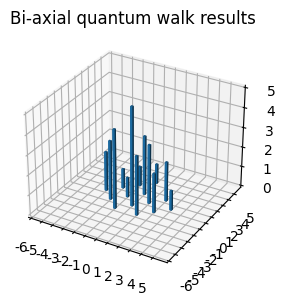

In [17]:
x, y, val = arrange_2d_data(counts)

# set up the figure and axes
fig = plt.figure(figsize=(7, 5))
ax = fig.add_subplot(121, projection='3d')

bottom = np.zeros_like(val)

# In a 3D bar chart, x and y are coordinates on the ground, bottom is where the bars start,
# width and depth are the dimensions of the bars, and val is the important parameters.
ax.bar3d(x, y, bottom, 0.2, 0.2, val, shade=True)

# Focus around the possible range.  Mark all ticks and do not label.
ax.set_xlim([-STEPS-1,STEPS+1])
ax.set_ylim([-STEPS-1,STEPS+1])
ax.set_xticks(range(-STEPS-1, STEPS+1))
ax.set_yticks(range(-STEPS-1, STEPS+1))
ax.set_xticklabels(range(-STEPS-1, STEPS+1))
ax.set_yticklabels(range(-STEPS-1, STEPS+1))
ax.set_title('Bi-axial quantum walk results')

### Representing this as a graph
Remember that random walks are performed on graphs - the random walk above, for example, is performed on a graph that looks like this:

![title="A grid of nodes"]("./Node grid.png")

It may also be fun to consider the results of a similar graph that has the diagonals.

![title="A grid of more-often-connected nodes"]("./Node grid diags.png")

In this case, each node has eight connections, rather than four, and if one is careful, one can cause any of the eight connections to occur with the same probability.  It is tempting to simply make motion on either axis independent - simply re-flip the axial coin, and give it an independent one-half chance of moving on each axis.  This is erroneous.  It would cause the odds of moving on both axes to be 1 in 4 with each step - however, half the connections on each node involve motion on both axes; the odds should be 1 in 2.  The odds of motion on each axes are independent - but they are 3 in 4.

The independence enables us to use separate coins (or to re-flip the same coin); we need merely change the odds of the coin by using a unitary gate instead of a Hadamard.  Though multiple Hadamard coins could be used to produce a binary fraction, this technique will prove useful when the number of connections on a node is not a power of 2, and non-binary probabilities are needed.

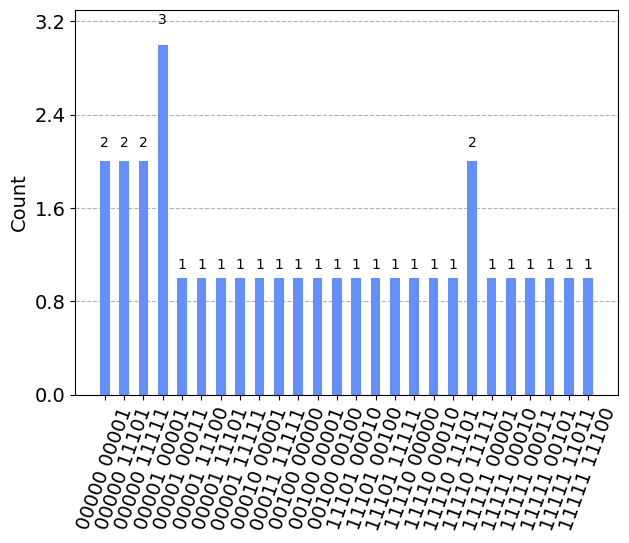

In [20]:
def super_flip(circuit, coin, prob):
    circuit.initialize('0', coin)
    circuit.rx(math.pi*prob, coin) # The rx gate rotates a given amount around the x-axis.

# Create a new circuit with the same registers
x_pos_q = QuantumRegister(REGISTER_LENGTH)
y_pos_q = QuantumRegister(REGISTER_LENGTH)
x_anc = QuantumRegister(REGISTER_LENGTH - 1)
y_anc = QuantumRegister(REGISTER_LENGTH - 1)
x_pos = ClassicalRegister(REGISTER_LENGTH)
y_pos = ClassicalRegister(REGISTER_LENGTH)
two_bit_coin = QuantumRegister(1)
axial_coin = QuantumRegister(1)
diag_qc = QuantumCircuit(x_pos_q, y_pos_q, x_anc, y_anc, x_pos, y_pos, axial_coin, two_bit_coin)

# Implement so many steps
for s in range(STEPS):
    super_flip(diag_qc, axial_coin, 0.75)
    flip(diag_qc, two_bit_coin)
    might_crement(diag_qc, x_pos_q, x_anc, two_bit_coin, axial_coin)
    super_flip(diag_qc, axial_coin, 0.75)
    flip(diag_qc, two_bit_coin)
    might_crement(diag_qc, y_pos_q, y_anc, two_bit_coin, axial_coin)

diag_qc.measure(x_pos_q, x_pos)
diag_qc.measure(y_pos_q, y_pos)

# Retrieve results
job = execute(diag_qc, backend, shots=2**5)
result = job.result()
counts = result.get_counts()
# plot_histogram(counts)

Text(0.5, 0.92, 'Bi-axial quantum walk results')

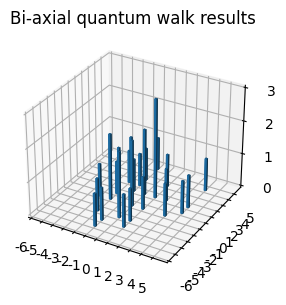

In [21]:
x, y, val = arrange_2d_data(counts)

# set up the figure and axes
fig = plt.figure(figsize=(7, 5))
ax = fig.add_subplot(121, projection='3d')

bottom = np.zeros_like(val)

# In a 3D bar chart, x and y are coordinates on the ground, bottom is where the bars start,
# width and depth are the dimensions of the bars, and val is the important parameters.
ax.bar3d(x, y, bottom, 0.2, 0.2, val, shade=True)

# Focus around the possible range.  Mark all ticks and do not label.
ax.set_xlim([-STEPS-1,STEPS+1])
ax.set_ylim([-STEPS-1,STEPS+1])
ax.set_xticks(range(-STEPS-1, STEPS+1))
ax.set_yticks(range(-STEPS-1, STEPS+1))
ax.set_xticklabels(range(-STEPS-1, STEPS+1))
ax.set_yticklabels(range(-STEPS-1, STEPS+1))
ax.set_title('Bi-axial quantum walk results')

## Two node case
In order to consider random walks in the most generic sense, apart from the rigidities of a coordinate plane and in the freeflow of nodes and connections, it is easier to start with the simplest such case:  two nodes, connected.

In general, a random walk on a given grid of nodes in quantum computing is performed by assigning a distinct state (an arrangement of 0s and 1s in a select set of measured bits) to represent each node and determining the circuitry that would convert qubits in any state to any of the states of the nodes to which its current state's node is connected with equal probability.  The operations may require additional qubits to perform accurately, and the qubits to be measured may be in superposition states at some point, possibly preserving some other, more vague information regarding position in its angles (this is especially the case in a random walk about points on spheroids).

Note that there are multiple ways to achieve this, even for the simplest case:  two nodes, connected to each other.  The most apparent solution is likely the use of a one-qubit register to indicate state:  one node corresponds to 0, the other to 1.  An x-gate on that qubit would indicate a step, as it would convert 0 to 1 and vice versa.  Yet other options are possible, for example:
* A two-qubit register, in which the states 01 and 10 represent each node.  A swap gate performs a step.
* A two-qubit register, in which the states 00 and 11 represent each node.  Two x-gates perform a step.
* A two-qubit register, in which the states 00 and 01 represent each node.  An x-gate on one qubit performs a step.
Of course, in the last case, the first qubit (which, according to convention, is ironically the "most significant" bit) is purposeless, because it never changes; in the second case, the two qubits are redundant, because they always have the same value.  The first case may have some value if the qubits held more information (especially if they were entangled to be opposite), and this were part of the state register of a larger system.  In the case of both it and the original solution, it should be apparent that the gates representing a series of steps can be collapsed into at most one gate (one or none, depending on the parity<sup><a name="myfootnote3">2</a></sup> of the number of steps/gates); of course, it was also apparent in the original problem where a random walk would end based on the parity of the number of steps.

<sup>[3](#myfootnote3)Parity is the property of being even or odd - an even number of steps back and forth lands the walker on the original state; an odd number lands the walker on the other.</sup>

## Three node case
In the case of three nodes, there are two possible problems:  the case of three nodes connected in a triangle, and that of three nodes connected in a "V" (or a finite line).  In either case, the three states require at least two qubits to be indicated - and those two can resolve to any of four states: 00, 01, 10, and 11.  One state will not correspond to a node - and if the qubits resolve to that state (and the circuit was initialized to a valid state), then it will be apparent that the logic used to conduct each step is not correct for every number of steps.

In this notebook, one considers (or at least, presents a solution for) the case of three nodes connected in a triangle.  In this case, since each node is has two connections, I presume the need for one coin, and consider six cases.
| Initial state | Coin | Final state |
|---|---|---|
| 01 | 0 | 10 |
| 01 | 1 | 11 |
| 10 | 0 | 01 |
| 10 | 1 | 11 |
| 11 | 0 | 01 | 
| 11 | 1 | 10 |

The way the four gates achieve this is described in the comments of the code below, and the proof that they do so can be shown by initializing the circuit below to any valid state and observing that the result after one step is either of the other two states.  The way the gates were determined was by trial and error - the first column of the table is not known upon starting the problem, as it is not clear which state should be omitted (I failed, repeatedly, when attempting to omit 11 or 10, the latter attempt suggesting omitting 01 would be equally difficult, and would like to prove their impossibility if possible).  Similarly, it is not clear which result of the coin should cause which other state - so long as the two results cause different other valid states.  I chose states, wrote the first two columns, and tried to find what resulted in an acceptable third column, making it look more like what was desired with clever gates.

In [ ]:
def three_node_step(circuit, state, coin):
    circuit.initialize('0',coin)
    circuit.h(coin)

    circuit.toffoli(coin, state[0], state[1]) # Changes 01|1 to 11|1 and 11|1 to 01|1
    circuit.toffoli(state[1], state[0], coin) # Only changes 11|0 to 11|1 and 01|1->11|1 to 11|0
    circuit.toffoli(coin, state[1], state[0]) # Changes 10|1 to 11|1 and 11|0->11|1 to 10|1
    circuit.swap(state[1], state[0]) # Changes 01|0 to 10|0, 10|0 to 01|0, and 11|0->->10|1 and 11|1->01|1 to each other.

qnode = QuantumRegister(2)
node = ClassicalRegister(2)
coin = QuantumRegister(1)
three_node_circuit = QuantumCircuit(qnode, node, coin)

three_node_circuit.initialize('01',qnode)
three_node_step(three_node_circuit, qnode, coin)

three_node_circuit.measure(qnode, node)
job = execute(three_node_circuit, backend, shots=20)
result = job.result()
counts = result.get_counts()
plot_histogram(counts)

The results of a random walk on three nodes are that, after infinite steps, the walker has an equal 1 in 3 chance of being on any node. (The long proof of this can be done in two parts - trying to find an expression for the probability of being in a non-initial state after so many steps, and showing that the infinite series $1/2 - 1/4 + 1/8 - 1/16 = \sum_{n=1}^{\infty} -(-\frac{1}{2})^n$ sums to 1/3).  In the code below, these results are confirmed for any initial state.

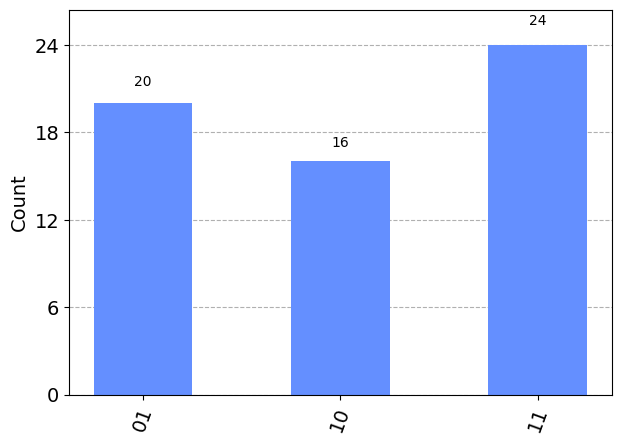

In [20]:
qnode = QuantumRegister(2)
node = ClassicalRegister(2)
coin = QuantumRegister(1)
three_node_long = QuantumCircuit(qnode, node, coin)

three_node_long.initialize('10',qnode)
for s in range(STEPS):
    three_node_step(three_node_long, qnode, coin)

three_node_long.measure(qnode, node)
job = execute(three_node_long, backend, shots=60)
result = job.result()
counts = result.get_counts()
plot_histogram(counts)

The above histogram should contain bars of comparable measure for any initial state except 00, in which case, no controlled gate is ever powered, and the circuit always remains in the state 00, as suggested in the diagram below:

![title="Three nodes in a triangle, one separate"](./Three_nodes.png)

I suspect that, in general, it will be advantageous to omit states with more zeroes, using the ones of the valid states to power elaborately controlled gates to perform specific operations in a few cases.

### Exercise to the reader
Find a series of gates that will perform a step on a random walk on a set of three nodes, two of which have only one connection, to the third node.

In [ ]:
# Exercise

## Four node case

The case of four nodes has arguably been considered above, for a random walk on a line with only two qubits in the register - it corresponds to the diagram below.  As a reminder, each step is performed via an x-gate on the less significant bit and a cx-gate on the more significant bit, the control being a Hadamard coin.

![title="Four nodes, two's complement"](./Four_two_c_nodes.png)

It may be noted that in this case, the x-gates for so many steps simplify, as in the case of two nodes, while the cx-gates could all be replaced by a single Hadamard regardless of their parity - after any number of maybe-flips, the more significant qubit will have half a chance of being 0 or 1.

Of course, there is no obligation, for this case of a square of four nodes, to think of four numbers in two's complement notation.  One could, alternatively, consider two separate versions of the two-node case, in which only one carries out its step in each step of the whole.  Each qubit represents a different two-node case.  This effectively "multiplies" the two-node case by two, resulting in a square like this one:

![title="Four nodes, gray codes"](./Four_gray_nodes.png)

Two observations:
* This ends up equivalent to the use of Gray codes to encode values on a line of length 4, as suggested earlier.
* A third "coin" qubit can ensure that only one state qubit is swapped (H the coin, cx, X the coin, cx)
    * If the swaps on each qubit are the same, one has the same four states connected in an X, two isolated sets of two nodes.
    * If the swaps on each qubit are indepedent, one has the same four states connected with the square, diagonals, and *each to itself* (should neither swap occur), which is discouraged in a random walk
* Starting in state 00, the results of the four node case simplify to a Hadamard gate on one qubit, a cx-gate controlled by it onto the other qubit, and an x-gate on either qubit should the number of steps be odd.
* This can continue to be multiplied indefinitely:

![title="Hypercube"](./Hypercube_nodes.png)

Some ways of finding the unitary matrix and the gates for a step on a multiplied group of two-node sets (a hypercube) are shown in "Quantum walk processes in quantum devices" by Madhu, Melnikov, et al., which is worth a read.

## Twelve-node case

This sort of "multiplication" is, of course, not limited to two-node, one-qubit cases.  It should also be noted that it does not have all the properties of traditional multiplication, as it has different forms.  When combining a system of x nodes, represented by m qubits, with one combining a system of y nodes, represented by n qubits, resulting in a system of x*y nodes, represented by m+n qubits, the steps in the two subsystems may or may not be performed in each step of the large system.  There are multiple ways to do this, namely:
1. Steps in both subsystems are performed
2. Steps in the x-node subsystem are always performed; steps in the y-node subsystem have a chance of being performed (the chance should, for a fair random walk, be $\frac{a}{a+1}$, where a node in the y-node subsystem has $a$ connections).
3. A step in one random subsystem is performed, with a probability corresponding to the proportion of connections between nodes in that subsystem to the sum of the connections between nodes in each subsystem.
4. A step in each subsystem may or may not be performed, independently, with probability $\frac{a}{a+1}$ as before.

The probabilities above ensure the fairness of a random walk - this becomes apparent when drawing the connections that result in multiplying systems.  Take, for example, the case of multiplying the triangle:
![title="Triangle"](./Three_nodes.png)
by the square:
![title="Square"](./Four_gray_nodes.png)
in the simplest form - where steps in both subsystems are performed.  The nodes can be diagrammed by making a square where each corner is a triangle, and numbering them by their corresponding node in the large square and their small triangle (in the example below, the number in the square comes "first" in the register).  For the case where both steps are performed, each node is connected to each of the two nodes corresponding to other points on the triangle in the triangle for an adjacent corner of the square - four connections in all.

This produces a hideous graph I made on paper exclusively (I don't own a drawing tablet, and Google Drawings wasn't built for this), which can be untangled (not in any quantum sense, but a regular sense, into a drawing like the one below):

![title="Twelve nodes"](./Twelve_nodes.png)

The implementation of this is easy - it's simply all the registers from the square and the triangle, both steps performed, and both measured.  In future notebooks, we'll explore the other ways of multiplying systems.